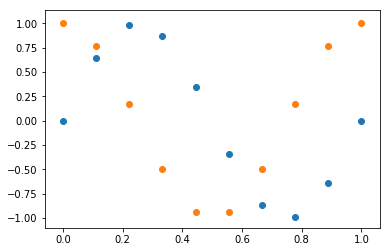

In [24]:
import math
import numpy as np
from scipy.io import loadmat
import torch
import gpytorch
from matplotlib import pyplot as plt
import dk_kernel
train_x = torch.linspace(0, 1, 10)
train_y = torch.stack(
    [torch.sin(train_x * (2 * math.pi)),
     torch.cos(train_x * (2 * math.pi))],-1) 
plt.scatter(train_x.numpy(),train_y[:,0].numpy())
plt.scatter(train_x.numpy(),train_y[:,1].numpy())
plt.show()
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        self.covar_module = dk_kernel.MultitaskRBFKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)
model.covar_module.log_task_outputscales[0] = 0
model.covar_module.log_task_outputscales[1] = 0

In [25]:
torch.set_printoptions(precision=4)
print(model.covar_module(train_x,train_x).size())
print(model.covar_module(train_x,train_x).evaluate())


torch.Size([20, 20])
tensor([[1.0000, 0.9938, 0.9756, 0.9460, 0.9060, 0.8570, 0.8007, 0.7390, 0.6736,
         0.6065, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.9938, 1.0000, 0.9938, 0.9756, 0.9460, 0.9060, 0.8570, 0.8007, 0.7390,
         0.6736, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.9756, 0.9938, 1.0000, 0.9938, 0.9756, 0.9460, 0.9060, 0.8570, 0.8007,
         0.7390, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.9460, 0.9756, 0.9938, 1.0000, 0.9938, 0.9756, 0.9460, 0.9060, 0.8570,
         0.8007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.9060, 0.9460, 0.9756, 0.9938, 1.0000, 0.9938, 0.9756, 0.9460, 0.9060,
         0.8570, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.8570, 0.9060, 0.9460, 0.9756

In [26]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.fast_pred_var():
    test_x = torch.linspace(0, 1, 1000)
    #predictions = likelihood(model(test_x))
    predictions = model(test_x)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

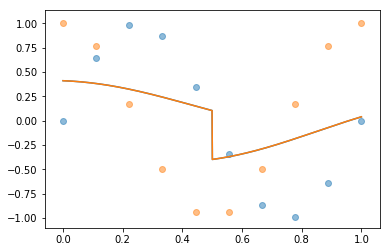

In [27]:
# training data and posterior mean from task 0
plt.scatter(train_x.detach().numpy(), train_y[:, 0].detach().numpy(),color='C0',alpha=0.5)
plt.plot(test_x.numpy(), mean[:, 0].numpy(), 'C0')
# training data and posterior mean from task 1
plt.scatter(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), color='C1',alpha=0.5)
plt.plot(test_x.numpy(), mean[:, 1].numpy(), 'C1')


In [19]:
print(predictions.covariance_matrix)
predictions.covariance_matrix.size()


tensor([[ 0.2900,  0.2651,  0.2362,  0.2044,  0.1708,  0.1366,  0.1028,  0.0707,
          0.0410,  0.0144,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.2651,  0.2490,  0.2288,  0.2051,  0.1788,  0.1508,  0.1221,  0.0936,
          0.0663,  0.0410,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.2362,  0.2288,  0.2174,  0.2023,  0.1840,  0.1632,  0.1407,  0.1172,
          0.0936,  0.0707,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.2044,  0.2051,  0.2023,  0.1959,  0.1861,  0.1733,  0.1580,  0.1407,
          0.1221,  0.1028,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
          0.0000, -0.0000,  0.0000, -0.0000],
        [ 0.1708,  0.1788,  0.1840,  0.1861,  0.1850,  0.1807,  0.1733,  0.1632,
          0.1508,  0.1366,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
      

torch.Size([20, 20])